In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np 
import scipy.io as sio
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme()
%matplotlib inline

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.set_default_dtype(torch.float32)

In [3]:
# Reading the Comp. Matrix - N x (D + y)
data = sio.loadmat("./Dataset//No_nan_matrix.mat")["training_matrix"]

# Feature Matrix - N x 2 (ax, ay)
X = data[:, :-1]

# Targets - N 
y = data[:, -1] #[:, np.newaxis]

# Target vdot (N - 1) x 1
y = np.diff(y).reshape(-1, 1)

# Feature Matrix - (N - 1) x 2
X = X[:-1]

# Normalization
mu = X.mean()
sigma = X.std()

# Normalized Dataset
X_norm = (X - mu) / sigma

X_norm.shape, y.shape, mu, sigma

((27434, 2), (27434, 1), -0.006798274760917822, 0.2688761963031729)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((19752, 2), (2195, 2), (5487, 2), (19752, 1), (2195, 1), (5487, 1))

In [5]:
train_data = np.concatenate((X_train, y_train), axis=1)
val_data = np.concatenate((X_val, y_val), axis=1)
test_data = np.concatenate((X_test, y_test), axis=1)

train_data.shape, val_data.shape, test_data.shape

((19752, 3), (2195, 3), (5487, 3))

In [6]:
np.save("./Dataset/train_v.npy", train_data.astype(np.float32))
np.save("./Dataset/val_v.npy", val_data.astype(np.float32))
np.save("./Dataset/test_v.npy", test_data.astype(np.float32))

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [8]:
# Expressive GRU
class ProGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ProGRU, self).__init__()
        self.lstm = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=2, bidirectional=True, batch_first=True)
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        self.activation = nn.PReLU()
    
    def forward(self, x):
        batch_size = x.shape[0]
        out, hn = self.lstm(x.view(batch_size, 1, -1))
        out = self.activation(self.linear1(hn[0])) 
        out = self.activation(self.linear2(out))
        out = self.linear3(out)
        return out
    
# Expressive LSTM v2
class ProLSTM2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ProLSTM2, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=2, bidirectional=True, batch_first=True)
        self.linear1 = nn.Linear(hidden_size, hidden_size) # nn.Linear(hidden_size * 2, hidden_size) for self lstm_out
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        self.activation = nn.PReLU()
    
    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros((4, batch_size, 512), device=device, requires_grad=True)
        c0 = torch.zeros((4, batch_size, 512), device=device, requires_grad=True)
        out, (hn, cn) = self.lstm(x.view(batch_size, 1, -1), (h0, c0))
        out = self.activation(self.linear1(hn[0]))
        # out = self.activation(self.linear1(out.view(batch_size, -1))) # self.linear1(hn[0])
        out = self.activation(self.linear2(out))
        out = self.linear3(out)
        return out

In [10]:
# Custom Dataset Loader 
class TrajDataset(Dataset):
    """Expert Trajectory Dataset."""
    def __init__(self, data):
        
        # Inputs
        self.x = data[:, :-1]
        
        # Output
        self.y = data[:, -1]
        
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        
        # Inputs
        inp = self.x[idx]
        inp = inp.flatten()
        
        # Outputs
        out = self.y[idx]
        out = out.flatten()
        
        return torch.tensor(inp).float(), torch.tensor(out).float()

# Load the dataset
train_data = np.load("./Dataset/train_v.npy")
val_data = np.load("./Dataset/val_v.npy")
test_data = np.load("./Dataset/test_v.npy")

# Using PyTorch Dataloader
train_dataset = TrajDataset(train_data)
val_dataset = TrajDataset(val_data)
test_dataset = TrajDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

In [11]:
for batch_num, (datas) in enumerate(train_loader):
    inp, out = datas
    print(inp.shape, out.shape)
    break

torch.Size([64, 2]) torch.Size([64, 1])


In [12]:
# ToyMLP Inputs
input_size = 2
hidden_size = 512
output_size = 1

epochs = 150
model = ProLSTM2(input_size, hidden_size, output_size).to(device)
optimizer = optim.AdamW(model.parameters(), lr = 6e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma = 0.1)
loss_fn = nn.MSELoss()

avg_train_loss, avg_val_loss = [], []
for epoch in range(epochs):

    # Train Loop
    losses_train = []
    model.train()
    for inp, out in train_loader:

        inp = inp.to(device)
        out = out.to(device)

        # Forward Pass
        pred = model(inp)
        loss = loss_fn(pred, out)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_train.append(loss.detach().cpu().numpy())

    # Val Loop
    losses_val = []
    model.eval()
    for inp, out in val_loader:

        inp = inp.to(device)
        out = out.to(device)

        # No Gradients
        with torch.no_grad():
            pred = model(inp)
            test_loss = loss_fn(pred, out)

        losses_val.append(test_loss.detach().cpu().numpy())

    print(f"Epoch: {epoch + 1}, Train Loss: {np.average(losses_train):.3f},  Val Loss: {np.average(losses_val):.3f}")

    scheduler.step()
    avg_train_loss.append(np.average(losses_train)), avg_val_loss.append(np.average(losses_val))

Epoch: 1, Train Loss: 0.150,  Val Loss: 0.101
Epoch: 2, Train Loss: 0.141,  Val Loss: 0.097
Epoch: 3, Train Loss: 0.140,  Val Loss: 0.098
Epoch: 4, Train Loss: 0.140,  Val Loss: 0.097
Epoch: 5, Train Loss: 0.141,  Val Loss: 0.097
Epoch: 6, Train Loss: 0.141,  Val Loss: 0.098
Epoch: 7, Train Loss: 0.140,  Val Loss: 0.098
Epoch: 8, Train Loss: 0.142,  Val Loss: 0.098
Epoch: 9, Train Loss: 0.140,  Val Loss: 0.098
Epoch: 10, Train Loss: 0.140,  Val Loss: 0.098
Epoch: 11, Train Loss: 0.140,  Val Loss: 0.099
Epoch: 12, Train Loss: 0.140,  Val Loss: 0.141
Epoch: 13, Train Loss: 2.304,  Val Loss: 0.097
Epoch: 14, Train Loss: 0.142,  Val Loss: 0.096
Epoch: 15, Train Loss: 0.143,  Val Loss: 0.099
Epoch: 16, Train Loss: 0.139,  Val Loss: 0.096
Epoch: 17, Train Loss: 0.139,  Val Loss: 0.096
Epoch: 18, Train Loss: 0.139,  Val Loss: 0.096
Epoch: 19, Train Loss: 0.139,  Val Loss: 0.096
Epoch: 20, Train Loss: 0.139,  Val Loss: 0.096
Epoch: 21, Train Loss: 0.139,  Val Loss: 0.097
Epoch: 22, Train Loss:

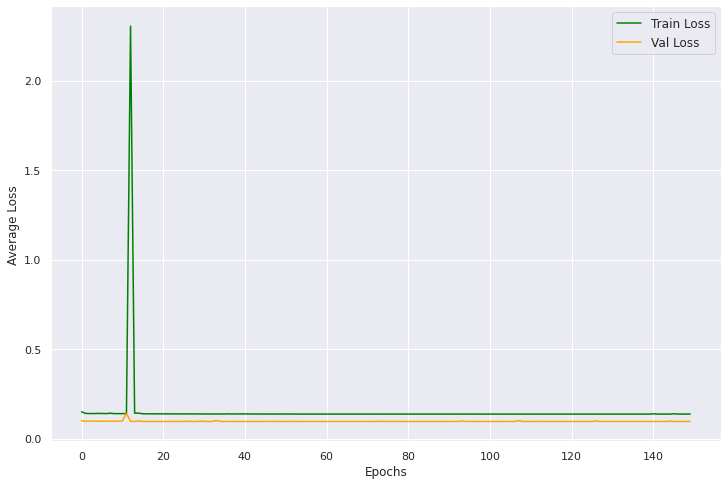

In [13]:
e = np.arange(epoch+1)

plt.figure( figsize=(12, 8))
plt.plot(e, np.array(avg_train_loss), label="Train Loss", color="green")
plt.plot(e, np.array(avg_val_loss), label="Val Loss", color="orange")
plt.legend(loc=1 ,prop={'size': 12})
# plt.ylim([0, 30])
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.show()

In [14]:
# Load the Test Dataset
test_set = torch.from_numpy(test_data)

# Feature and Ground Truth Matrix
X = test_set[:, :-1].to(device)
y = test_set[:, -1].reshape(-1, 1).to(device)

# Inference
with torch.no_grad():
    model.eval()
    test_pred = model(X)

test_loss = loss_fn(test_pred, y)    

print(f"Test MSE Loss: {test_loss:.3f}")

test_set.shape, X.shape, y.shape, test_pred.shape

Test MSE Loss: 0.133


(torch.Size([5487, 3]),
 torch.Size([5487, 2]),
 torch.Size([5487, 1]),
 torch.Size([5487, 1]))

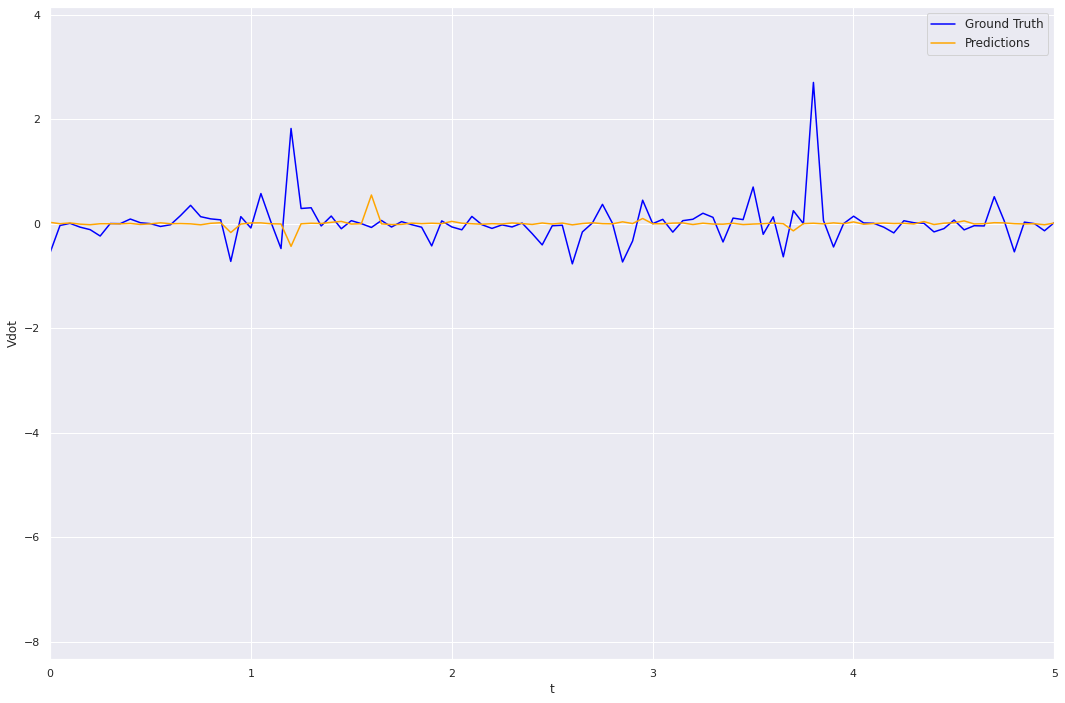

In [15]:
t = np.linspace(0, X.shape[0], X.shape[0])*0.05

# %matplotlib qt
plt.figure( figsize=(18, 12))
plt.plot(t, y.cpu().numpy(), label="Ground Truth", color="blue")
plt.plot(t, test_pred.cpu().numpy(), label="Predictions", color="orange")
plt.legend(loc=1 ,prop={'size': 12})
plt.xlim(0, 5)
# plt.ylim(-10, 10)
plt.xlabel("t")
plt.ylabel("Vdot")
# plt.savefig("GRU Predictions.png")
plt.show()

### Two Baselines

RNN Neural Network

x1 = [ax1 ay1] at t1

x1 -> h1 -> v1_hat (h0, v0) initial

x2 -> h2 + h1 + v1_hat -> v2_hat and so on 

MSELoss (v_hat, v_gt)

Approach 2: Map (ax, ay) -> v2 - v1 (Take Diff over the column)

Discard the last row from the training set :)